# Integrating Multiple Datasets

In this tutorial, we will integrate two related samples together.



In [1]:
import stlearn as st
import scanpy as sc
import harmonypy as hm
import pathlib as pathlib
import numpy as np
import random as random
import os as os

st.settings.set_figure_params(dpi=120)

# Make sure all the seeds are set
seed = 0
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this 

## Read data

In this tutorial, we are using the Breast cancer datasets with 2 sections of block A.

Source:
 * https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0 and
 * https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-2-1-standard-1-1-0


In [2]:
st.settings.datasetdir = pathlib.Path.cwd().parent / "data"

In [3]:
block1 = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
block1 = st.convert_scanpy(block1)

/var/folders/j9/xg__c_rx4jdgzs2r1dqd43hr0000gn/T/ipykernel_42856/3199448693.py:1: FutureWarning: Use `squidpy.datasets.visium` instead.
  block1 = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
block2 = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_2")
block2 = st.convert_scanpy(block2)

/var/folders/j9/xg__c_rx4jdgzs2r1dqd43hr0000gn/T/ipykernel_42856/3718500169.py:1: FutureWarning: Use `squidpy.datasets.visium` instead.
  block2 = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_2")
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Processing data

In [5]:
# concatenate 2 samples
adata_concat = block1.concatenate(block2)

/var/folders/j9/xg__c_rx4jdgzs2r1dqd43hr0000gn/T/ipykernel_42856/1934939955.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = block1.concatenate(block2)


In [6]:
# Preprocessing
# Filter genes
sc.pp.filter_genes(adata_concat, min_cells=3)
# Normalize data
sc.pp.normalize_total(adata_concat, target_sum=1e4)
# Log transformation
sc.pp.log1p(adata_concat)
# Store raw data
adata_concat.raw = adata_concat
# Extract top highly variable genes
sc.pp.highly_variable_genes(adata_concat, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_concat = adata_concat[:, adata_concat.var.highly_variable]
# Scale data
sc.pp.scale(adata_concat, max_value=10)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/andrew/conda/stlearn/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [7]:
# Run dimensionality reduction
sc.pp.pca(adata_concat, n_comps=30, svd_solver='arpack')

/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


## Run integration with harmony

In [8]:
# Prepare metadata and PCA
meta_data = adata_concat.obs
data_mat = adata_concat.obsm["X_pca"]

In [9]:
# Run harmony
ho = hm.run_harmony(data_mat, meta_data, "batch")

2025-10-17 14:33:30,575 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-17 14:33:32,692 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-17 14:33:32,712 - harmonypy - INFO - Iteration 1 of 10
2025-10-17 14:33:33,471 - harmonypy - INFO - Iteration 2 of 10
2025-10-17 14:33:34,287 - harmonypy - INFO - Iteration 3 of 10
2025-10-17 14:33:35,228 - harmonypy - INFO - Iteration 4 of 10
2025-10-17 14:33:36,147 - harmonypy - INFO - Iteration 5 of 10
2025-10-17 14:33:37,204 - harmonypy - INFO - Iteration 6 of 10
2025-10-17 14:33:37,967 - harmonypy - INFO - Iteration 7 of 10
2025-10-17 14:33:38,351 - harmonypy - INFO - Iteration 8 of 10
2025-10-17 14:33:38,746 - harmonypy - INFO - Iteration 9 of 10
2025-10-17 14:33:39,133 - harmonypy - INFO - Iteration 10 of 10
2025-10-17 14:33:39,586 - harmonypy - INFO - Converged after 10 iterations


In [10]:
# Mapping back the result to the adata object
adata_concat.obsm["X_pca"] = ho.Z_corr.T

## Perform clustering and visualize the results by UMAP

In [11]:
# Build KNN and run UMAP
sc.pp.neighbors(adata_concat, n_pcs=30)
sc.tl.umap(adata_concat)

/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


In [38]:
# Run clustering with leiden
sc.tl.leiden(adata_concat, resolution=0.46)

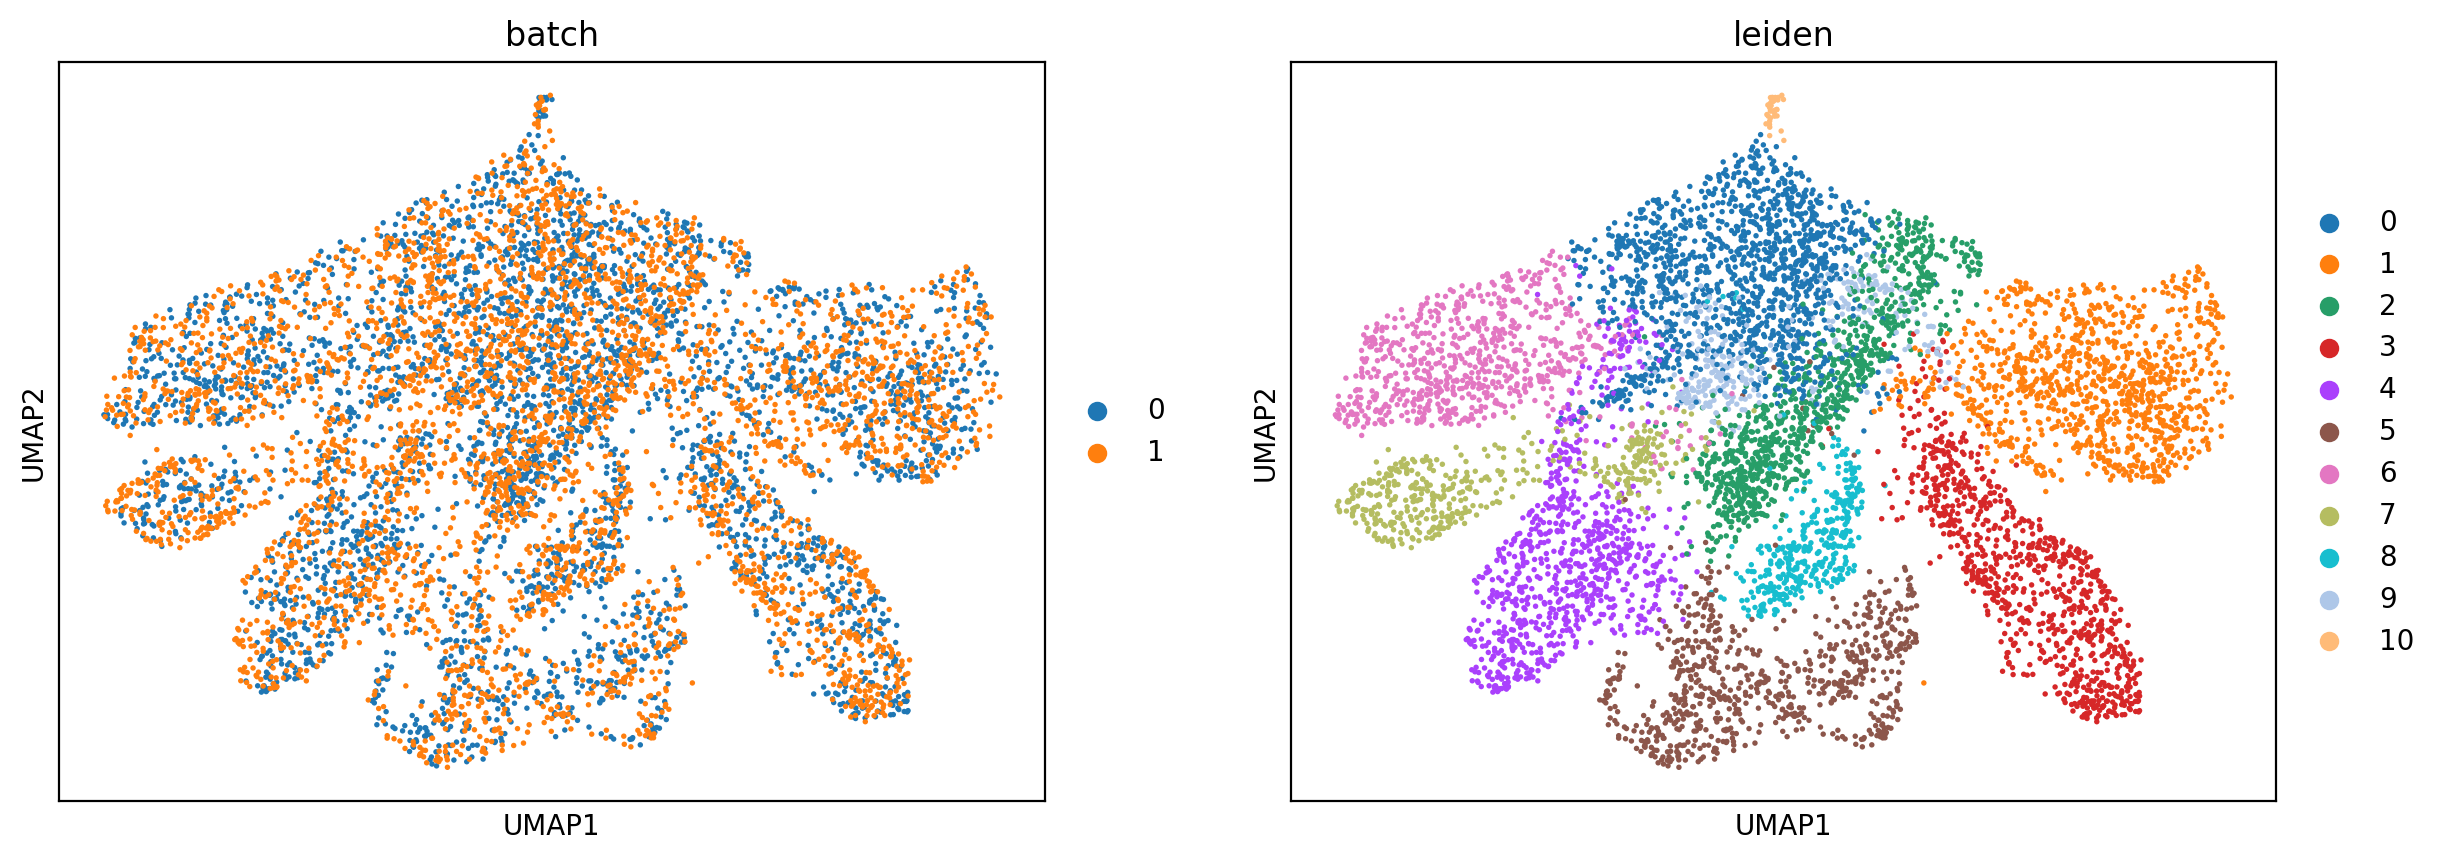

In [40]:
# Plotting UMAP
sc.pl.umap(adata_concat, color=["batch","leiden"])

## Map the result back to the original samples


In [41]:
st.settings.set_figure_params(dpi=150)
# Map leiden clusteirng result to block A section 1
block1.obs["leiden"] = adata_concat.obs[adata_concat.obs.batch=="0"].leiden.values

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'leiden_colors'
    obsm: 'spatial'

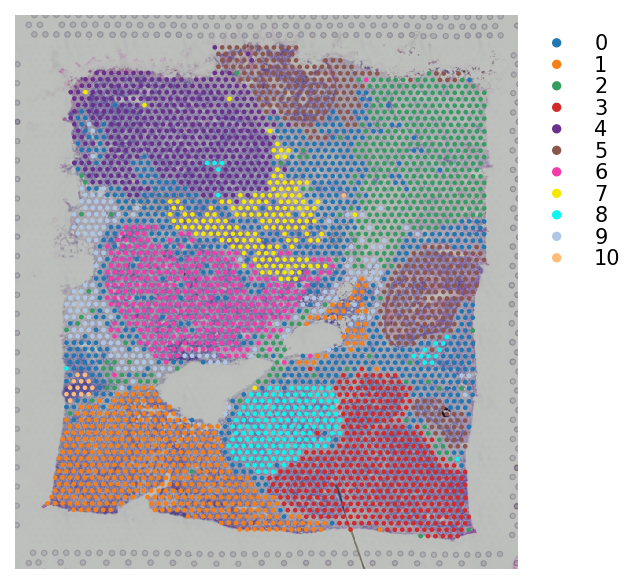

In [42]:
# Plotting the clusteirng result
st.pl.cluster_plot(block1,use_label="leiden")

In [43]:
# Map leiden clustering result to block A section 2
block2.obs["leiden"] = adata_concat.obs[adata_concat.obs.batch=="1"].leiden.values

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'leiden_colors'
    obsm: 'spatial'

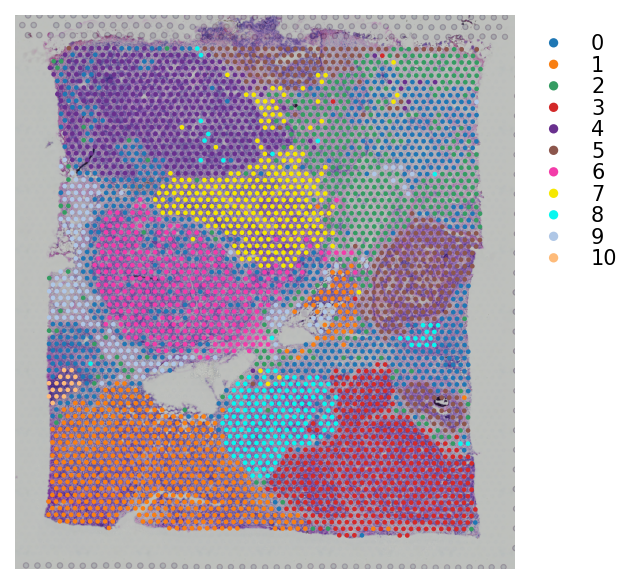

In [44]:
# Plotting the clustering result
st.pl.cluster_plot(block2,use_label="leiden")

## Manually combine the images and change the coordinates

This is a way to plotting 2 samples in the same adata object. 

In [45]:
# Initialize the spatial 
adata_concat.uns["spatial"] = block1.uns["spatial"]

In [46]:
# Horizontally stack 2 images from section 1 and section 2 datasets
combined = np.hstack([block1.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["hires"],
                      block2.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_2"]["images"]["hires"]])

In [47]:
# Map the image to the concatnated adata object
adata_concat.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["hires"] = combined

In [48]:
# Manually change the coordinate of spots to the right
adata_concat.obs.loc[adata_concat.obs.batch == "1","imagecol"] = adata_concat.obs.loc[adata_concat.obs.batch == "1","imagecol"].values + 2000

In [49]:
# Change to the .obsm["spatial"]
factor = adata_concat.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["scalefactors"]["tissue_hires_scalef"]
adata_concat.obsm["spatial"] = adata_concat.obs[["imagecol","imagerow"]].values / factor

In [50]:
st.settings.set_figure_params(dpi=200)

AnnData object with n_obs × n_vars = 7785 × 3018
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'batch', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'batch_colors', 'leiden_colors', 'spatial'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

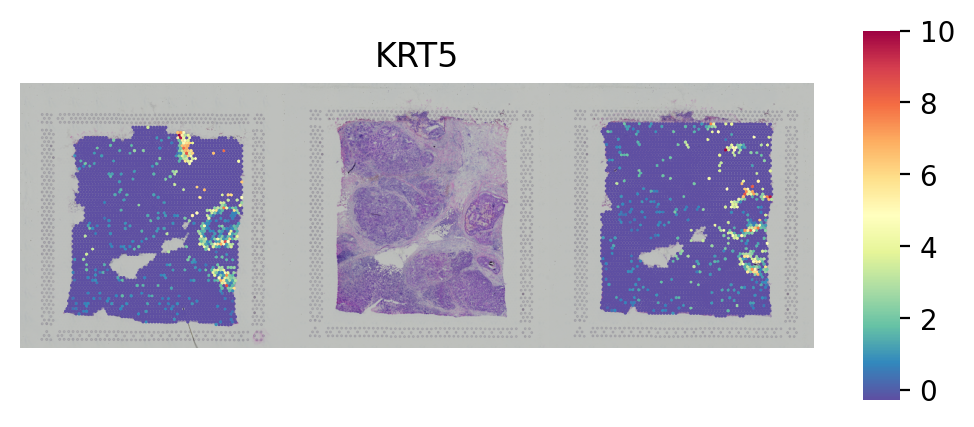

In [51]:
# Plot the gene
st.pl.gene_plot(adata_concat, gene_symbols="KRT5",crop=False, size=1.4,cell_alpha=1)

AnnData object with n_obs × n_vars = 7785 × 3018
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'batch', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'batch_colors', 'leiden_colors', 'spatial'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

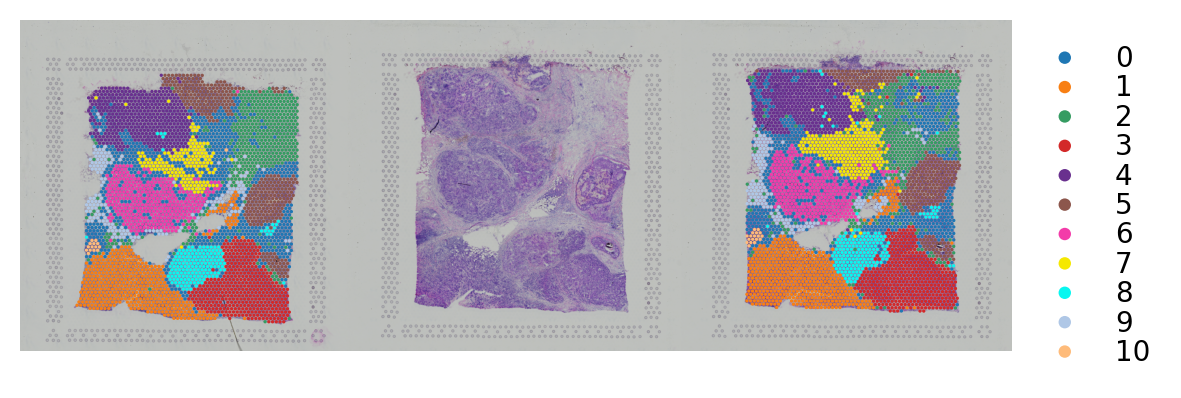

In [52]:
# Plot the clusters
st.pl.cluster_plot(adata_concat, use_label="leiden", crop=False, size=1.4,cell_alpha=1)